# Association & Sequential Rules algorithms: Validation & Comparison

In this notebook, we will show how to validate the RecPack algorithms using RecPack Pipeline. Metrics will be used here to compare the algorithms.

In [1]:
import numpy as np
import pandas as pd
from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.scenarios import Timed, TimedLastItemPrediction
from recpack.pipelines import PipelineBuilder

In [2]:
transactions = pd.read_feather('transactions_train_preproc.feather')

In [3]:
transactions

,index,t_dat,customer_id,article_id,price,sales_channel_id,week
0,25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
1,25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
2,5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
3,5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
4,47429,2018-09-20,2918879973994241,662980001,0.033881,1,0
...,...,...,...,...,...,...,...
31788319,31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104
31788320,31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104
31788321,31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104
31788322,31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104


In [4]:
test_week = transactions.week.max()
transactions = transactions[transactions.week > test_week - 10]

# Checking the results of the algorithms:

## `TimedLastItemPrediction` scenario

### Preprocessing

In [6]:
proc = DataFramePreprocessor(item_ix='article_id', user_ix='customer_id', timestamp_ix='week')
proc.add_filter(MinUsersPerItem(10, item_ix='article_id', user_ix='customer_id'))
proc.add_filter(MinItemsPerUser(10, item_ix='article_id', user_ix='customer_id'))

interaction_matrix = proc.process(transactions)

  0%|          | 0/1228106 [00:00<?, ?it/s]

  0%|          | 0/1228106 [00:00<?, ?it/s]

(array([126710., 131222., 145802., 133000., 122952., 114875., 122603.,
        113551., 113942., 103449.]),
 array([ 95. ,  95.9,  96.8,  97.7,  98.6,  99.5, 100.4, 101.3, 102.2,
        103.1, 104. ]),
 <BarContainer object of 10 artists>)

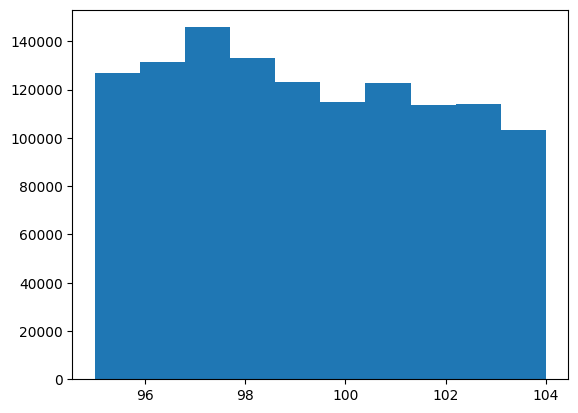

In [7]:
import matplotlib.pyplot as plt
plt.hist(interaction_matrix.timestamps.values)

In [10]:
t_70 = interaction_matrix.timestamps.values[int(0.7 * len(interaction_matrix.timestamps.values))]
t_validate_70 = interaction_matrix.timestamps.values[int(0.7 * 0.7 * len(interaction_matrix.timestamps.values))]
print(t_70, t_validate_70)

101 99


In [18]:
scenario = TimedLastItemPrediction(t=t_80, t_validation=t_validate_80, validation=True)
scenario.split(interaction_matrix)

/home/jupyter/recpack/scenarios/splitters.py:187: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_ts_per_user = data.timestamps.max(level=0)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/home/jupyter/recpack/matrix/interaction_matrix.py:407: UserWarning: No interaction IDs given, returning empty InteractionMatrix.
  warnings.warn("No interaction IDs given, returning empty InteractionMatrix.")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [11]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class AssociationRules(TopKItemSimilarityMatrixAlgorithm):
    def __init__(self, K=200):
        super().__init__(K)

    def _fit(self, X: csr_matrix):
        """
        Trains the predictor.

        """
        X_binary = to_binary(X)
        X_T_binary = csr_matrix(X_binary.transpose())

        # CO_matrix = X_T_binary @ X_binary

        CO_matrix = csr_matrix(X_T_binary @ X_binary)

        # Here we get the best rules
        CO_matrix = get_top_K_values(CO_matrix, self.K)

        # Normalization of CO_matrix
        CO_array = CO_matrix.toarray()

        diag = np.diagonal(CO_array)
        sim_matrix = CO_array/diag[:, None]
        similarity = csr_matrix(sim_matrix)
        # similarity = get_top_K_values(similarity, self.K)

        self.similarity_matrix_ = similarity

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X

In [12]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class AssociationRulesExtensionLastItem(AssociationRules):
    def __init__(self, K=200):
        super().__init__(K)

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

In [13]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

class AssociationRulesExtension(AssociationRules):
    def __init__(self, K=200, k_items = 200):
        super().__init__(K)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X

In [14]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class SequentialRules(ItemSimilarityMatrixAlgorithm):
    def __init__(self, max_steps=20):
        self.max_steps = max_steps

    def _transform_fit_input(self, X: Matrix) -> InteractionMatrix:
        # X_interaction_matrix = isinstance(X, InteractionMatrix)
        if isinstance(X, InteractionMatrix) == False:
            raise ValueError(f"Interaction Matrix")
        elif X.has_timestamps == False:
            raise ValueError(f"requires timestamp information")
        else:
            return X

    def _fit(self, X: InteractionMatrix):
        a = list(X.sorted_item_history)
        sim_matrix = lil_matrix((X.shape[1], X.shape[1]))
        for user, items_per_user in X.sorted_item_history:
            for i in range(0, len(items_per_user) - 1):
                for n_steps, j in enumerate(
                    range(i + 1, min(len(items_per_user), i + self.max_steps + 1)),
                    start=1,
                ):
                    LHS = items_per_user[i]
                    RHS = items_per_user[j]
                    sim_matrix[LHS, RHS] += 1 / n_steps
        support = csr_matrix(X.values.sum(axis=0))

        sim_matrix = sim_matrix.multiply(invert(support).T)
        self.similarity_matrix_ = sim_matrix.tocsr()

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X

In [15]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class SequentialRulesExtensionLastItem(SequentialRules):
    def __init__(self, max_steps=20):
        super().__init__(max_steps)

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

In [16]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks


class SequentialRulesExtension(SequentialRules):
    def __init__(self, max_steps=20, k_items = 200):
        super().__init__(max_steps)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X

In [17]:
from recpack.pipelines import ALGORITHM_REGISTRY, PipelineBuilder, pipeline_builder

ALGORITHM_REGISTRY.register('AssociationRules', AssociationRules)
ALGORITHM_REGISTRY.register('SequentialRules', SequentialRules)
ALGORITHM_REGISTRY.register('AssociationRulesExLast', AssociationRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('SequentialRulesExLast', SequentialRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('AssociationRulesEx', AssociationRulesExtension)
ALGORITHM_REGISTRY.register('SequentialRulesEx', SequentialRulesExtension)

In [19]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)

builder.add_algorithm('AssociationRules', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRules', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesExLast', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRulesExLast', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesEx', grid={
    'K': [100, 200, 500, 1000, 2000, 5000],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})

builder.add_algorithm('SequentialRulesEx', grid={
    'max_steps': [10, 20, 30, 50, 100],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})



builder.add_metric('PrecisionK', K=[12, 20, 30, 40])
builder.add_metric('RecallK', K=[12, 20, 30, 40])
builder.add_metric('CoverageK', K=[12, 20, 30, 40])

builder.set_optimisation_metric('RecallK', K=12)

In [20]:
pipeline = builder.build()
pipeline.run()

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


2022-12-18 10:45:17,971 - base - recpack - INFO - Fitting AssociationRules complete - Took 17.8s
2022-12-18 10:46:08,674 - base - recpack - INFO - Fitting AssociationRules complete - Took 18.5s
2022-12-18 10:47:04,878 - base - recpack - INFO - Fitting AssociationRules complete - Took 20.5s
2022-12-18 10:48:07,975 - base - recpack - INFO - Fitting AssociationRules complete - Took 22.0s
2022-12-18 10:49:20,775 - base - recpack - INFO - Fitting AssociationRules complete - Took 24.4s
2022-12-18 10:50:36,606 - base - recpack - INFO - Fitting AssociationRules complete - Took 24.5s
2022-12-18 10:51:43,724 - base - recpack - INFO - Fitting AssociationRules complete - Took 14.7s


/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2022-12-18 10:55:35,644 - base - recpack - INFO - Fitting SequentialRules complete - Took 78.0s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 33 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 10:57:15,350 - base - recpack - INFO - Fitting SequentialRules complete - Took 84.4s
2022-12-18 10:58:55,988 - base - recpack - INFO - Fitting SequentialRules complete - Took 83.3s
2022-12-18 11:00:38,453 - base - recpack - INFO - Fitting SequentialRules complete - Took 83.6s
2022-12-18 11:02:21,851 - base - recpack - INFO - Fitting SequentialRules complete - Took 85.7s
2022-12-18 11:04:28,106 - base - recpack - INFO - Fitting SequentialRules complete - Took 1.08e+02s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 9 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:06:26,778 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 17.6s
2022-12-18 11:07:15,067 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 19.1s
2022-12-18 11:08:05,960 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 21.5s
2022-12-18 11:08:58,718 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 22.4s
2022-12-18 11:09:54,123 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 23.8s
2022-12-18 11:10:50,733 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 24.1s
2022-12-18 11:11:37,131 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 14.3s
2022-12-18 11:14:59,925 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 77.7s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtensionLastItem missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtensionLastItem failed to recommend any items for 8283 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:16:25,765 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 82.5s
2022-12-18 11:17:52,814 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 84.4s
2022-12-18 11:19:19,903 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 84.4s
2022-12-18 11:20:45,872 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 83.4s
2022-12-18 11:22:42,824 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 1.14e+02s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtensionLastItem missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtensionLastItem failed to recommend any items for 21342 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:23:19,625 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.4s
2022-12-18 11:24:13,061 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.5s
2022-12-18 11:25:06,821 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.9s
2022-12-18 11:25:59,320 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.5s
2022-12-18 11:26:53,133 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.4s
2022-12-18 11:27:46,110 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.5s
2022-12-18 11:28:41,165 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.7s
2022-12-18 11:29:38,109 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.4s
2022-12-18 11:30:34,874 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.5s
2022-12-18 11:31:32,142 - base - recpack - INF

/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtension missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtension failed to recommend any items for 33 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 12:08:39,598 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 81.0s
2022-12-18 12:10:20,166 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 82.5s
2022-12-18 12:12:02,804 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 84.2s
2022-12-18 12:13:45,165 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 83.1s
2022-12-18 12:15:21,402 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 77.1s
2022-12-18 12:16:58,877 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 81.2s
2022-12-18 12:18:41,370 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 83.8s
2022-12-18 12:20:25,105 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 85.2s
2022-12-18 12:22:09,019 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 85.3s
2022-12-18 12:23:44,811 - base - recpack - INFO - Fitti

/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtension missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtension failed to recommend any items for 9 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


In [21]:
pipeline.optimisation_results

,identifier,params,recallk_12
0,AssociationRules(K=100),{'K': 100},0.061589
1,AssociationRules(K=200),{'K': 200},0.061318
2,AssociationRules(K=500),{'K': 500},0.060777
3,AssociationRules(K=1000),{'K': 1000},0.060566
4,AssociationRules(K=2000),{'K': 2000},0.060536
...,...,...,...
83,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 10}",0.064389
84,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 20}",0.064931
85,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 30}",0.064931
86,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 50}",0.064901


In [22]:
pd.DataFrame.from_dict(pipeline.get_metrics()).T

,AssociationRules(K=100),SequentialRules(max_steps=20),AssociationRulesExtensionLastItem(K=100),"SequentialRulesExtensionLastItem(k_items=200,max_steps=100)","AssociationRulesExtension(K=100,k_items=100)","SequentialRulesExtension(k_items=100,max_steps=100)"
precisionk_12,0.002460,0.003358,0.002751,0.002204,0.003057,0.004096
precisionk_20,0.001850,0.002685,0.001877,0.001540,0.002199,0.003138
precisionk_30,0.001478,0.002207,0.001392,0.001152,0.001668,0.002560
precisionk_40,0.001270,0.001890,0.001128,0.000946,0.001391,0.002197
recallk_12,0.029516,0.040301,0.033009,0.026452,0.036686,0.049146
recallk_20,0.036992,0.053701,0.037544,0.030803,0.043978,0.062750
recallk_30,0.044346,0.066223,0.041772,0.034562,0.050045,0.076804
recallk_40,0.050780,0.075598,0.045122,0.037830,0.055642,0.087875
coveragek_12,0.571130,0.733903,0.565481,0.711305,0.581921,0.751616
coveragek_20,0.670280,0.794625,0.635415,0.790910,0.679646,0.820634
